In [1]:
import matplotlib.pyplot as plt
import torch.sparse as sp
from scipy.sparse import lil_matrix
import torch
import json

import numpy as np
from scipy.sparse import lil_matrix

## New laplacian code

In [2]:
def create_laplacian_matrix(n):
    # Total number of grid points
    total_points = n * n

    laplacian = lil_matrix((total_points, total_points))
    
    # Fill the matrix based on finite difference method for Laplacian
    for i in range(n):
        for j in range(n):
            row = i * n + j  # Current grid point
            
            # Diagonal element
            laplacian[row, row] = 4
            
            # Check and update neighbors (left, right, up, down)
            if i > 0:
                laplacian[row, (i - 1) * n + j] = -1  # Up
            if i < n - 1:
                laplacian[row, (i + 1) * n + j] = -1  # Down
            if j > 0:
                laplacian[row, i * n + (j - 1)] = -1  # Left
            if j < n - 1:
                laplacian[row, i * n + (j + 1)] = -1  # Right
    
    # Convert to CSR format for efficient arithmetic operations
    
    laplacian = laplacian.tocsr()
    laplacian = -laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(laplacian.shape[0]):
        start = laplacian.indptr[row]
        end = laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(laplacian.indices[start:end])
        values.extend(laplacian.data[start:end])
    
    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
        torch.tensor([row_indices, col_indices], dtype=torch.int64),
        torch.tensor(values, dtype=torch.float32),
        torch.Size((n*n,n*n))
    )

    return coo_matrix

# Example usage
grid_size = 3  # Change this value to adjust the grid size
laplacian_matrix = create_laplacian_matrix(grid_size)

print(laplacian_matrix.to_dense())  # Print the dense representation for visualization

tensor([[-4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 1., -4.,  1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1., -4.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -4.,  1.,  0.,  1.,  0.,  0.],
        [ 0.,  1.,  0.,  1., -4.,  1.,  0.,  1.,  0.],
        [ 0.,  0.,  1.,  0.,  1., -4.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  1.,  0.,  0., -4.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  1., -4.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  1., -4.]])


## Rewrite the original code using torch

In [36]:

# Simulating the TDGL equation
a, b, k = -1.0, 1.0, 100.0 #configuração: (a<0, b>0) ou (a>0, b>0)
dh, dt = 1.0, 1e-3
Ng, Tf = 50, 10001

a = torch.tensor(a, device='cpu')
b = torch.tensor(b, device='cpu')
k = torch.tensor(k, device='cpu')
dh = torch.tensor(dh, device='cpu')
dt = torch.tensor(dt, device='cpu')
Ng = torch.tensor(Ng, device='cpu')
Tf = torch.tensor(Tf, device='cpu')
T = torch.tensor([0.1], device='cpu')

# Ng, Tf = 64, 10001
master_list = []


def laplacian(n):
    # Total number of grid points
    total_points = n * n

    matrix_laplacian = lil_matrix((total_points, total_points))
    
    # Fill the matrix based on finite difference method for Laplacian
    for i in range(n):
        for j in range(n):
            row = i * n + j  # Current grid point
            
            # Diagonal element
            matrix_laplacian[row, row] = 4
            
            # Check and update neighbors (left, right, up, down)
            if i > 0:
                matrix_laplacian[row, (i - 1) * n + j] = -1  # Up
            if i < n - 1:
                matrix_laplacian[row, (i + 1) * n + j] = -1  # Down
            if j > 0:
                matrix_laplacian[row, i * n + (j - 1)] = -1  # Left
            if j < n - 1:
                matrix_laplacian[row, i * n + (j + 1)] = -1  # Right
    
    # Convert to CSR format for efficient arithmetic operations
    
    matrix_laplacian = matrix_laplacian.tocsr()
    matrix_laplacian = -matrix_laplacian

    # Extract coordinates and values
    row_indices = []
    col_indices = []
    values = []

    for row in range(matrix_laplacian.shape[0]):
        start = matrix_laplacian.indptr[row]
        end = matrix_laplacian.indptr[row + 1]
        row_indices.extend([row] * (end - start))
        col_indices.extend(matrix_laplacian.indices[start:end])
        values.extend(matrix_laplacian.data[start:end])
    
    # convert to coo_matrix
    coo_matrix = torch.sparse_coo_tensor(
        torch.tensor([row_indices, col_indices], dtype=torch.int64),
        torch.tensor(values, dtype=torch.float32),
        torch.Size((n*n,n*n))
    )

    return coo_matrix

def integrate(L, u):
    '''  simulates the equation and plots it at different instants '''

    #f = plt.figure(figsize=(15, 15), dpi=80);

    for i in range(Tf.item()):
        noise = torch.normal(mean=0.0, std=1.0, size=(Ng * Ng, 1), device='cpu')
        u = u - dt * (a * u + b * u * u * u - k * torch.mm(L, u)) + torch.sqrt(2 * T * dt) * noise  # Euler's method

        # if (i==0):      configPlot(x, y, u, f, 1, i);
        # if (i==1):      configPlot(x, y, u, f, 2, i);
        # if (i==10):     configPlot(x, y, u, f, 3, i);
        # if (i==100):    configPlot(x, y, u, f, 4, i);
        # if (i==1000):   configPlot(x, y, u, f, 5, i);
        if (i==10000):
            master_list.append(u)
            #configPlot(x, y, u, f, 6, i)


def configPlot(x, y, u,f, n_, i):
    u = u.view((Ng, Ng))
    u = u.cpu()
    U = u.numpy()
    sp =  f.add_subplot(3, 3, n_ )
    plt.setp(sp.get_yticklabels(), visible=False)
    plt.setp(sp.get_xticklabels(), visible=False)
    plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu);
    plt.title('Time=%d'%i)


In [37]:
# generate the grid and initialise the field

## define o dispositivo cuda a ser utilizado

device = torch.device('cpu')


x = torch.linspace(-1, 1, Ng)
y = torch.linspace(-1, 1, Ng)
X, Y = torch.meshgrid(x, y)

## simula 100 configurações finais com os parametros iniciais

#L = L.to_dense()
L = laplacian(Ng)
L = L.to(device)         # construct the laplacian
for i in range(5):
  u = torch.randn(Ng * Ng, 1, device=device)  # Initial data
  integrate(L, u)    # simulate
  print(f'Time = {i+1}/5')


## salva estas configurações em um arquivo JSON

mlist = [[] for _ in range(5)]
num = 0
for l in master_list:
    l = l.cpu()
    for i in range(len(l)):
        mlist[num].append(l[i].item())
    num+=1

# file_path = 'data_configs_a_pos_b_pos.json'

# with open(file_path, 'w') as json_file:
#    json.dump(mlist, json_file)

c:\Users\mille\Documents\CloneGit\ising-models\venv\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Time = 1/5
Time = 2/5
Time = 3/5
Time = 4/5
Time = 5/5


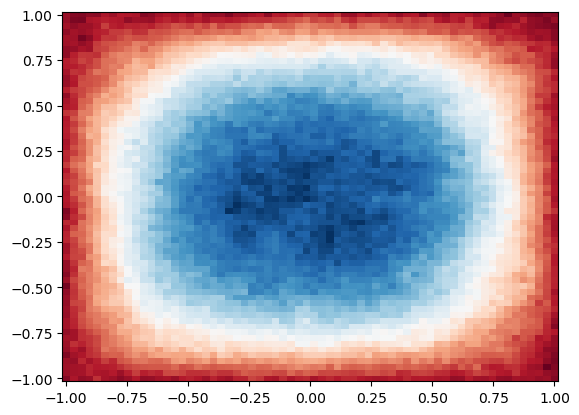

In [38]:
## visualizar a configuração final individualmente

x = torch.linspace(-1, 1, Ng)
y = torch.linspace(-1, 1, Ng)
X, Y = torch.meshgrid(x, y)

u = master_list[0]
u = u.view((Ng, Ng))
u = u.cpu()
U = u.numpy()

plt.pcolormesh(x,y,U, cmap=plt.cm.RdBu)

## Calculate the mean of configurations

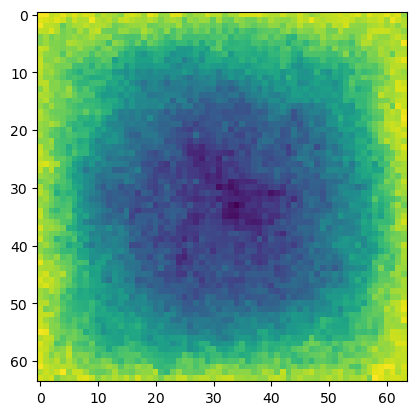

In [40]:
mean_config = []
size = len(master_list)
N = 64*64
temp = 0

for point in range(N):
    for config in range(size):
        temp += master_list[config][point]
    mean_config.append(temp/size)
    temp = 0

mean_config = torch.tensor(mean_config)
mean_config = mean_config.view((Ng, Ng))
plt.imshow(mean_config)
    